---
title: "Extraction of features"
---


In this script, we will extract effort-related features from the merged multimodal data we created for each trial in script @ADDREF. 

Because we are dealing with time-varying data, we will extract number of statistics that characterize both instantaneous as well as cumulative nature of each (acoustic, motion, postural) timeseries in terms of effort. 

Before we collect all relevant features, we normalize all time-varying features in the trial by minimum and maximum observed values for that feature for a participant. This is because we want to account for individual differences/strategies in using the whole range of motion and/or acoustic features. We therefore treat effort as a relative measure - but because we cannot access information about the minimum/maximum possible by a participant, we take the maximum and minimum that were observed within the whole experiment.

In [2]:
#| code-fold: true
#| code-summary: Code to prepare the environment

# Import packages
import os
import glob
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import antropy as ent
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
import seaborn as sns
import builtins


curfolder = os.getcwd()

# Here we store our merged final timeseries data
mergedfolder = curfolder + "\\..\\05_finalMerge\\TS_final\\"
filestotrack = glob.glob(mergedfolder + "merged_anno*.csv")

# Here we store concept similarity data
conceptsimfolder = curfolder + "\\..\\06_ConceptSimilarity\\data\\"

# Here we store voice quality measures
voicefolder = curfolder + "\\..\\03_TS_processing\\TS_acoustics\\"

# Here we store other potentially useful data
metadatafolder = curfolder + "\\..\\00_RAWDATA\\"

# Here we store the final data
datafolder = curfolder + "\\Datasets\\"

# These are practice trials
practicetrials = ['0_2_0', '0_2_1', '0_2_19', '0_2_20', '0_2_21', '0_2_22', '0_2_38', '0_2_39', '0_2_40', '0_2_53', '0_2_54', '0_2_55', '0_2_56', '0_2_67', '0_2_68', '0_2_69', '0_2_70', '0_2_71', '0_2_72', '0_2_92', '0_2_93', '0_2_94', '0_2_95', '0_2_96', '0_2_97']

# We are interested only in data from part 2, and only those that are not practice trials
files_part2 = []  

# Collect to list only files that are in part 2 and are not practice trials
for file in filestotrack:
    exp_part = file.split("\\")[-1].split("_")[3]
    if exp_part == "2":
        if not any([x in file for x in practicetrials]):
            files_part2.append(file)

# Preparing additional metadata

To get additional metadata about the trials, we also need to load in and pre-process some more data, such as:

- Similarity between answer and a target concept (created in @ADDREF). This dataframe has information about the similarity between an answer and performed target concept, computed as cosine similarity of embeddings retrieved from ConceptNet

- Expressibility of a concept. This dataframe has information about expressibility of each concept in a stimuli list. The ratings were acquired from a separate group of people that participated in an online study (see @kadava_etal24).

- Response time. This dataframe has information about how long it took a guesser to provide an answer to a performance, measured from the end of the performance until pressing an Enter to confirm the answer.

This is the similarity dataframe

In [3]:
#| echo: false

# Load in similarity from ConceptNet
similarityfile = conceptsimfolder + "df_final_conceptnet.csv"
similaritydata = pd.read_csv(similarityfile)

# Keep only rows where exp = 2
similaritydata = similaritydata[similaritydata['exp'] == 2]
similaritydata = similaritydata.reset_index(drop=True)

# In similarity data, create index column that tracks the row number
similaritydata['index'] = similaritydata.index

# In practicetrials list, for each element, keep only the last element separated by "_"
practicetrials2 = [x.split("_")[-1] for x in practicetrials]

# Convert the list to integers
practicetrials2 = [int(x) for x in practicetrials2]

# Keep only those rows that have index that is NOT in the practicetrials2 list
similaritydata = similaritydata[similaritydata['index'].apply(lambda x: x not in practicetrials2)]

# We don't need exp col anymore
similaritydata = similaritydata.drop(columns=['exp'])

# Round cosine_similarity and mean_similarity to 3 decimal places
similaritydata['cosine_similarity'] = similaritydata['cosine_similarity'].round(3)
similaritydata['mean_similarity'] = similaritydata['mean_similarity'].round(3)

similaritydata.head(15)

word     answer    English  answer_en  cosine_similarity  \
2        vrouw    zwanger     female   pregnant              0.265   
3        vrouw       haar     female       hair              0.236   
4        vrouw    douchen     female  to shower              0.025   
5   verbranden       pijn    to burn       pain              0.119   
6   verbranden   verbrand    to burn      burnt              0.883   
7   verbranden       heet    to burn        hot              0.412   
8           ik         ik          I          I              1.000   
9       kauwen     kauwen    to chew    to chew              1.000   
10     vliegen      vogel     to fly       bird              0.433   
11     vliegen  vliegtuig     to fly   airplane              0.745   
12     vliegen    vliegen     to fly     to fly              1.000   
13   misschien     denken      maybe   to think              0.567   
14   misschien     kiezen      maybe  to choose              0.159   
15   misschien  twijfelen      maybe   to doubt              0.284   
16     bliksem   graffiti  lightning   graffiti              0.012   

    mean_similarity  index  
2             4.929      2  
3             3.714      3  
4             0.571      4  
5             5.643      5  
6             8.714      6  
7             6.786      7  
8            10.000      8  
9            10.000      9  
10            7.143     10  
11            8.071     11  
12           10.000     12  
13            3.143     13  
14            3.643     14  
15            6.929     15  
16            0.571     16

This is the expressibility dataframe

In [4]:
#| echo: false

# Load in expressibility for Dutch
express_nl = metadatafolder + "expressibility_nl.csv"
express_df = pd.read_csv(express_nl)

# Rename modalities to Dutch to match it with the rest of the data
express_df['modality'] = express_df['modality'].replace(['gesture', 'multimodal', 'vocal'], ['gebaren', 'combinatie', 'geluiden'])

# Leave only word, modality and fit
express_df = express_df[['word', 'modality', 'fit']]

# Round fit
express_df['fit'] = express_df['fit'].round(3)

express_df.head(15)

word    modality    fit
0        aanraken     gebaren  0.671
1        aanraken  combinatie  0.695
2        aanraken    geluiden  0.207
3           aarde     gebaren  0.539
4           aarde  combinatie  0.524
5           aarde    geluiden  0.195
6          ademen     gebaren  0.782
7          ademen  combinatie  0.808
8          ademen    geluiden  0.785
9           alles     gebaren  0.351
10          alles  combinatie  0.381
11          alles    geluiden  0.118
12  arm (lichaam)     gebaren  0.537
13  arm (lichaam)  combinatie  0.575
14  arm (lichaam)    geluiden  0.127

This is the response time dataframe

In [5]:
#| echo: false

# In metadatafolder, find all csv files that might be in the folders in the metadatafolder
answerfiles = glob.glob(metadatafolder + "\\*\\*results.csv")

# Keep only those that have as second element in the filename "2"
answerfiles = [x for x in answerfiles if x.split("\\")[-1].split("_")[1] == "2"]

# Load all in df
answerdata = pd.concat([pd.read_csv(x) for x in answerfiles])

# add column index that tracks the row number
answerdata['index'] = answerdata.index

# keep only those rows that have index that is NOT in the practicetrials2 list
answerdata = answerdata[answerdata['index'].apply(lambda x: x not in practicetrials2)]

# create column TrialID that will consists of 0_2_ + the index + 'p'+cycle
answerdata['TrialID'] = '0_2_' + answerdata['index'].astype(str) + '_p' + answerdata['cycle'].astype(str)

# create colum response_time_sec that is RT - trial_end
answerdata['response_time_sec'] = answerdata['RT'] - answerdata['trial_end']

# now keep only TrialID and response_time_sec
answerdata = answerdata[['TrialID', 'response_time_sec']]

# round response_time_sec to 3 decimals
answerdata['response_time_sec'] = answerdata['response_time_sec'].round(3)

answerdata.head(15)

TrialID  response_time_sec
2    0_2_2_p0              5.112
3    0_2_3_p0             14.576
4    0_2_4_p0              4.008
5    0_2_5_p0              3.793
6    0_2_6_p0              6.091
7    0_2_7_p0              3.719
8    0_2_8_p0              6.466
9    0_2_9_p0              5.328
10  0_2_10_p0              2.727
11  0_2_11_p0              2.912
12  0_2_12_p0              4.849
13  0_2_13_p0              7.510
14  0_2_14_p0              3.823
15  0_2_15_p0              4.358
16  0_2_16_p0              5.861

# Z-scoring to get to relative effort

People can be expected to have a different range of effort, depending on factors including their bodily but also cognitive predispositions. To account for this, we will normalize all data by the means of z-scoring to transform all timeseries such that they represent a deviation from a person's grand mean for that particulat signal (we will include also data from preceseding experiment that the same participants were performing before this experiment, see [preregistration of data collection](https://osf.io/3nygq/)). We will now collect the means and standard deviations of each timeseries for each participant into a dictionary.

In [6]:
# Loop through all files and get maximum and minimum of all timeseries
zscore_dict = {}

sessions = ['0']
participants = ['p0', 'p1']

for session in sessions:
    for file in filestotrack:
        filesession = file.split("\\")[-1].split("_")[2]
        if filesession == session:
            filepart = file.split("\\")[-1].split("_")[5].split(".")[0]
            df_mega_p0 = pd.DataFrame()
            df_mega_p1 = pd.DataFrame()
            
            if filepart == 'p0':
                df_p0 = pd.read_csv(file)
                df_mega_p0 = pd.concat([df_mega_p0, df_p0])
            
            elif filepart == 'p1':
                df_p1 = pd.read_csv(file)
                df_mega_p1 = pd.concat([df_mega_p1, df_p1])
    
            dfs = [df_mega_p0, df_mega_p1]
            
            for df_mega in dfs:
                numcols = df_mega.select_dtypes(include=[np.number]).columns
                numcols = [x for x in numcols if 'time' not in x]

                for col in numcols:
                    mean = df_mega[col].mean()
                    std = df_mega[col].std()
                    pcnID = session + "_" + filepart
                    zscore_dict[pcnID + "_" + col] = (mean, std)


Now we can check that the normalization of the sample timeseries worked as expected by plotting it against the timeseries before normalization

In [7]:
# Function to z-score
def zscore(x, col, pcnID, zscore_dict):
    mean, std = zscore_dict[pcnID + "_" + col]
    return (x - mean) / std

# Z-score sample
sample = files_part2[40]
df_sample = pd.read_csv(sample)
numcols = df_sample.select_dtypes(include=[np.number]).columns  # Normalize only numerical columns (except time)
numcols = [x for x in numcols if x != 'time']

trialID = df_sample['TrialID'].iloc[0]
pcnID = trialID.split('_')[0] + '_' + trialID.split('_')[-1]

# Compute all z-scored columns at once
zscore_columns = pd.DataFrame({
    col + '_z': df_sample[col].apply(lambda x: zscore(x, col, pcnID, zscore_dict))
    for col in numcols
})

# Concatenate the z-scored columns all at once to avoid fragmentation
df_sample = pd.concat([df_sample, zscore_columns], axis=1).copy()

# Check the resulting dataframe
df_sample.head(15)

time  left_back  right_forward  right_back  left_forward     COPXc  \
0    0.0   1.125486       0.804025    1.585540      1.305944  0.000518   
1    2.0   1.125361       0.804328    1.585462      1.305529  0.000438   
2    4.0   1.125285       0.804542    1.585431      1.305204  0.000359   
3    6.0   1.125250       0.804683    1.585438      1.304959  0.000284   
4    8.0   1.125250       0.804762    1.585474      1.304782  0.000213   
5   10.0   1.125279       0.804791    1.585530      1.304662  0.000146   
6   12.0   1.125331       0.804780    1.585600      1.304591  0.000086   
7   14.0   1.125401       0.804738    1.585678      1.304559  0.000031   
8   16.0   1.125485       0.804673    1.585759      1.304560 -0.000018   
9   18.0   1.125579       0.804591    1.585838      1.304585 -0.000059   
10  20.0   1.125679       0.804499    1.585913      1.304628 -0.000095   
11  22.0   1.125781       0.804401    1.585981      1.304683 -0.000123   
12  24.0   1.125884       0.804302    1.586039      1.304745 -0.000145   
13  26.0   1.125984       0.804204    1.586087      1.304809 -0.000160   
14  28.0   1.126080       0.804111    1.586124      1.304872 -0.000169   

       COPYc      COPc   TrialID                     FileInfo  ...  \
0   0.000133  0.000535  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
1   0.000021  0.000438  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
2  -0.000064  0.000365  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
3  -0.000126  0.000311  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
4  -0.000169  0.000272  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
5  -0.000196  0.000245  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
6  -0.000210  0.000227  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
7  -0.000215  0.000217  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
8  -0.000212  0.000213  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
9  -0.000203  0.000212  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
10 -0.000191  0.000213  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
11 -0.000177  0.000215  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
12 -0.000162  0.000217  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
13 -0.000147  0.000218  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
14 -0.000134  0.000216  0_2_6_p0  p0_verbranden_combinatie_c1  ...   

    f1_clean_z  f2_clean_z  f3_clean_z  f1_clean_vel_z  f2_clean_vel_z  \
0          NaN         NaN         NaN             NaN             NaN   
1          NaN         NaN         NaN             NaN             NaN   
2          NaN         NaN         NaN             NaN             NaN   
3          NaN         NaN         NaN             NaN             NaN   
4          NaN         NaN         NaN             NaN             NaN   
5          NaN         NaN         NaN             NaN             NaN   
6          NaN         NaN         NaN             NaN             NaN   
7          NaN         NaN         NaN             NaN             NaN   
8          NaN         NaN         NaN             NaN             NaN   
9          NaN         NaN         NaN             NaN             NaN   
10         NaN         NaN         NaN             NaN             NaN   
11         NaN         NaN         NaN             NaN             NaN   
12         NaN         NaN         NaN             NaN             NaN   
13         NaN         NaN         NaN             NaN             NaN   
14         NaN         NaN         NaN             NaN             NaN   

    f3_clean_vel_z  lowerbody_power_z  leg_power_z  head_power_z  arm_power_z  
0              NaN           5.454043     0.445892     -0.996332     4.290422  
1              NaN           5.436372     0.439448     -0.994162     4.274307  
2              NaN           5.418702     0.433004     -0.991991     4.258192  
3              NaN           5.401031     0.426560     -0.989821     4.242077  
4              NaN           5.383361     0.420116     -0.987651     4.225962  
5              NaN           5.36

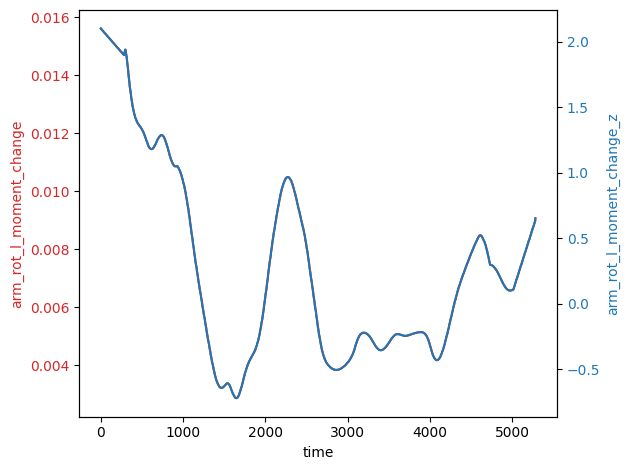

In [8]:
#| echo: false
   
# Plot both normalized and non-normalized lowerbody power
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('arm_rot_l_moment_change', color=color)
ax1.plot(df_sample['time'], df_sample['arm_rot_l_moment_change'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('arm_rot_l_moment_change_z', color=color)  # we already handled the x-label with ax1
ax2.plot(df_sample['time'], df_sample['arm_rot_l_moment_change_z'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Extracting features: rationale

In the following part, we will be extracting summaries from the existing timeseries that we pre-processed in the previous scripts. The goal is to capture the effort-related features that might be relevant in a repair, i.e., when a participant has to correct themselves to regain understanding with their partner who previously did not understand the performed concept.

Because we are dealing with time-varying data, we will extract number of statistics that characterize both instantaneous as well as cumulative nature of each (acoustic, motion, postural) timeseries in terms of effort. These are:

- global mean and standard deviation
- number, mean and standard deviation of the peaks (using function `find_peaks` from `scipy.signal`). For acceleration and moment change, we also calculate the measurements relating to negative peaks.
- range of the values
- integral 

Additionally, we will compute sample entropy to measure the complexity of a timeseries.

Furthermore, we will utilize measurements that capture characteristics beyond the statistics sketched above. These include:

- intermittency (as a dimensionless jerk, used in @pouw_etal21)
- bounding box of movement volume (i.e., gesture space, used in @zywiczynski_etal23)
- vowel space area (VSA, used in @berisha_etal14)
- motor complexity (computed as the slope of PCA; similar to @yan_etal20)
- number of submovements (used in @pouw_etal21)
- number of moving articulators


Before proceeding to the feature extraction for all trials, we will first demonstrate the features on a single trial.

In [9]:
#| echo: false

import tempfile
import subprocess
from IPython.display import Video

trialfolder = curfolder + "\\..\\01_XDF_processing\\data\\Data_processed\\Audiovideo\\"

# Create a temporary folder
temp_dir = tempfile.mkdtemp()

# Define input and output paths
avifiles = glob.glob(trialfolder+'\\*.avi')
sample = avifiles[60]

mp4_path = os.path.join(temp_dir, "converted_audiovideo.mp4")  # Save MP4 in temp folder

# Convert AVI to MP4 with video and audio
if not os.path.exists(mp4_path):
    subprocess.run([
        "ffmpeg", "-i", sample, 
        "-vcodec", "libx264", "-acodec", "aac", "-b:a", "192k",  # Ensure audio is included
        "-crf", "23", "-preset", "fast", mp4_path
    ])

# Display the video inside Jupyter Notebook
Video(mp4_path, embed=True, width=500)

This is a dataframe associated with this trial, for now with both zscored and original columns

In [10]:
#| echo: false

df_sample.head(15)

time  left_back  right_forward  right_back  left_forward     COPXc  \
0    0.0   1.125486       0.804025    1.585540      1.305944  0.000518   
1    2.0   1.125361       0.804328    1.585462      1.305529  0.000438   
2    4.0   1.125285       0.804542    1.585431      1.305204  0.000359   
3    6.0   1.125250       0.804683    1.585438      1.304959  0.000284   
4    8.0   1.125250       0.804762    1.585474      1.304782  0.000213   
5   10.0   1.125279       0.804791    1.585530      1.304662  0.000146   
6   12.0   1.125331       0.804780    1.585600      1.304591  0.000086   
7   14.0   1.125401       0.804738    1.585678      1.304559  0.000031   
8   16.0   1.125485       0.804673    1.585759      1.304560 -0.000018   
9   18.0   1.125579       0.804591    1.585838      1.304585 -0.000059   
10  20.0   1.125679       0.804499    1.585913      1.304628 -0.000095   
11  22.0   1.125781       0.804401    1.585981      1.304683 -0.000123   
12  24.0   1.125884       0.804302    1.586039      1.304745 -0.000145   
13  26.0   1.125984       0.804204    1.586087      1.304809 -0.000160   
14  28.0   1.126080       0.804111    1.586124      1.304872 -0.000169   

       COPYc      COPc   TrialID                     FileInfo  ...  \
0   0.000133  0.000535  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
1   0.000021  0.000438  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
2  -0.000064  0.000365  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
3  -0.000126  0.000311  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
4  -0.000169  0.000272  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
5  -0.000196  0.000245  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
6  -0.000210  0.000227  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
7  -0.000215  0.000217  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
8  -0.000212  0.000213  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
9  -0.000203  0.000212  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
10 -0.000191  0.000213  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
11 -0.000177  0.000215  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
12 -0.000162  0.000217  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
13 -0.000147  0.000218  0_2_6_p0  p0_verbranden_combinatie_c1  ...   
14 -0.000134  0.000216  0_2_6_p0  p0_verbranden_combinatie_c1  ...   

    f1_clean_z  f2_clean_z  f3_clean_z  f1_clean_vel_z  f2_clean_vel_z  \
0          NaN         NaN         NaN             NaN             NaN   
1          NaN         NaN         NaN             NaN             NaN   
2          NaN         NaN         NaN             NaN             NaN   
3          NaN         NaN         NaN             NaN             NaN   
4          NaN         NaN         NaN             NaN             NaN   
5          NaN         NaN         NaN             NaN             NaN   
6          NaN         NaN         NaN             NaN             NaN   
7          NaN         NaN         NaN             NaN             NaN   
8          NaN         NaN         NaN             NaN             NaN   
9          NaN         NaN         NaN             NaN             NaN   
10         NaN         NaN         NaN             NaN             NaN   
11         NaN         NaN         NaN             NaN             NaN   
12         NaN         NaN         NaN             NaN             NaN   
13         NaN         NaN         NaN             NaN             NaN   
14         NaN         NaN         NaN             NaN             NaN   

    f3_clean_vel_z  lowerbody_power_z  leg_power_z  head_power_z  arm_power_z  
0              NaN           5.454043     0.445892     -0.996332     4.290422  
1              NaN           5.436372     0.439448     -0.994162     4.274307  
2              NaN           5.418702     0.433004     -0.991991     4.258192  
3              NaN           5.401031     0.426560     -0.989821     4.242077  
4              NaN           5.383361     0.420116     -0.987651     4.225962  
5              NaN           5.36

### Basic statistics

Basic statistics capture properties of the timeseries in several dimensions:
- globally (mean, standard deviation of the timeseries, range of the values, rate of the feature)
- locally (number, mean and standard deviation of the peaks)
- cummulatively (integral of the timeseries)

We also collect the time stamps of the peaks, as we will use them to compute the synchronization between the modalities.

First, to be able to apply the `find_peaks` function properly, we will need for each column a mean value of the timeseries across all trials. This mean value is then set as the minimum height of a peak for a timeseries

In [10]:
df_list = []  # List to store individual DataFrames before concatenation

# First, collect all part2 trials into one z-score
for file in files_part2:   
    df = pd.read_csv(file)

    # Get all numerical cols
    numcols = df.select_dtypes(include=[np.number]).columns
    numcols = [x for x in numcols if x != 'time']  # Exclude 'time'

    # Normalize by observed mean and sd for this participant
    TrialID = df['TrialID'].iloc[0]  
    pcnID = TrialID.split('_')[0] + '_' + TrialID.split('_')[-1] 

    normalized_cols = {
        col + '_z': (df[col] - zscore_dict[pcnID + "_" + col][0]) / zscore_dict[pcnID + "_" + col][1]
        for col in numcols
    }

    df_normed = pd.DataFrame(normalized_cols)
    
    # Add necessary columns
    df_normed['TrialID'] = df['TrialID']
    df_normed['time'] = df['time']
    
    df_list.append(df_normed)  # Store in list instead of concatenating immediately

# Concatenate all at once to avoid fragmentation
df_mega = pd.concat(df_list, ignore_index=True)

# Compute general means
df_means = {col + '_general_mean': df_mega[col].mean() for col in df_mega.select_dtypes(include=[np.number]).columns if col != 'time'}
# Compute general std
df_means.update({col + '_general_std': df_mega[col].std() for col in df_mega.select_dtypes(include=[np.number]).columns if col != 'time'})
df_means = pd.DataFrame([df_means]) 


# Check the resulting df_means
df_means.head(15)

left_back_z_general_mean  right_forward_z_general_mean  \
0                   -1.8352                      1.496059   

   right_back_z_general_mean  left_forward_z_general_mean  \
0                  -1.401405                     1.723082   

   COPXc_z_general_mean  COPYc_z_general_mean  COPc_z_general_mean  \
0              0.039729              0.062733             1.667578   

   audio_z_general_mean  envelope_z_general_mean  \
0              3.723616                  0.09084   

   envelope_change_z_general_mean  ...  f1_clean_z_general_std  \
0                        -0.15375  ...                1.596439   

   f2_clean_z_general_std  f3_clean_z_general_std  f1_clean_vel_z_general_std  \
0                1.299107                1.054862                     1.94965   

   f2_clean_vel_z_general_std  f3_clean_vel_z_general_std  \
0                      1.3957                    0.974311   

   lowerbody_power_z_general_std  leg_power_z_general_std  \
0                       0.857923                 1.595838   

   head_power_z_general_std  arm_power_z_general_std  
0                  1.799934                 1.763681  

[1 rows x 1050 columns]

Now we can collect basic statistics.

Note that when we look for peaks, we take the mean value for that signal over all trials. Additionally, in timeseries that have both positive and negative values (e.g., acceleration), we will look for both positive and negative peaks.

In [11]:
#| code-fold: true
#| code-summary: Custom functions

# Function to calculate stats for a feature
def get_statistics(cols, df, subdf, dictionary, means_df):
    for col in cols:
        Gmean = subdf[col].mean()   # General mean
        Gstd = subdf[col].std()     # General std

        # If the col is 2nd derivative of position data, joint kinematics, or moments, we will calculate both positive and negative peaks (by reversing the sign of the data)
        if 'acc' in col or 'Acc' in col or 'moment_change' in col:
            ts_mean = means_df[col + '_z_general_mean'].values[0] # get the overall mean of this signal
            height = ts_mean - 2*df_means[col + '_z_general_std'].values[0] # height is mean - 1*std
            pospeaks, _ = find_peaks(subdf[col], height=height, distance=100)
            pospeaks_values = subdf.loc[pospeaks, col]
            pospeaks_times = subdf.loc[pospeaks, "time"].tolist()

            negpeaks, _ = find_peaks(-subdf[col], height=-height, distance=50, prominence=0.4)
            negpeaks_values = subdf.loc[negpeaks, col]
            negpeaks_times = subdf.loc[negpeaks, "time"].tolist()

            negpeak_mean = negpeaks_values.mean()
            negpeak_std = negpeaks_values.std()
            negpeak_n = len(negpeaks_values)

        else:    
            ts_mean = means_df[col + '_z_general_mean'].values[0] # get the overall mean of this signal
            height = ts_mean - 2*df_means[col + '_z_general_std'].values[0] # height is mean - 1*std
            pospeaks, _ = find_peaks(subdf[col], height=height, distance=50, prominence=0.4)

            pospeaks_values = df.loc[pospeaks, col] # Peak values
            pospeaks_times = df.loc[pospeaks, "time"].tolist() # Peak time

            # Plot if needed
            # peak_times = subdf.iloc[pospeaks]['time']
            # peak_values = subdf.iloc[pospeaks][col]
            # plt.plot(subdf['time'], subdf[col], label="Signal")
            # plt.scatter(peak_times, peak_values, color='r', label="Pos Peaks", marker="x")
            # plt.title(col)
            # plt.legend()
            # plt.show()

            pospeak_mean = pospeaks_values.mean() # Peak mean
            pospeak_std = pospeaks_values.std()   # Peak std
            pospeak_n = len(pospeaks_values)      # Number of peaks

            negpeak_mean = None
            negpeak_std = None
            negpeak_n = None
            negpeaks_times = None

        integral = np.trapz(subdf[col]) # Integral
        range = subdf[col].max() - subdf[col].min() # Range
        
        # Save all in dictionary
        dictionary[col] = [Gmean, Gstd, pospeak_mean, pospeak_std, pospeak_n, pospeaks_times, negpeak_mean, negpeak_std, negpeak_n, negpeaks_times, integral, range]

    return dictionary

# Function to adapt row
def adapt_row(row_to_process):
    for col in row_to_process.columns:
        # Calculate for all expcet some already calculated measures
        if 'inter' not in col and 'sampEn' not in col and 'bbmv' not in col and 'duration' not in col:
            row_to_process[col + '_Gmean'] = row_to_process[col].apply(lambda x: x[0])
            row_to_process[col + '_Gstd'] = row_to_process[col].apply(lambda x: x[1])
            row_to_process[col + '_pospeak_mean'] = row_to_process[col].apply(lambda x: x[2])
            row_to_process[col + '_pospeak_std'] = row_to_process[col].apply(lambda x: x[3])
            row_to_process[col + '_pospeak_n'] = row_to_process[col].apply(lambda x: x[4])
            row_to_process[col + '_pospeak_times'] = row_to_process[col].apply(lambda x: x[5])
            row_to_process[col + '_negpeak_mean'] = row_to_process[col].apply(lambda x: x[6])
            row_to_process[col + '_negpeak_std'] = row_to_process[col].apply(lambda x: x[7])
            row_to_process[col + '_negpeak_n'] = row_to_process[col].apply(lambda x: x[8])
            row_to_process[col + '_negpeak_times'] = row_to_process[col].apply(lambda x: x[9])
            row_to_process[col + '_integral'] = row_to_process[col].apply(lambda x: x[10])
            row_to_process[col + '_range'] = row_to_process[col].apply(lambda x: x[11])

    # Now keep only this newly created cols
    row_final = row_to_process[[col for col in row_to_process.columns if any(x in col for x in ['Gmean', 'Gstd', 'pospeak_mean', 'pospeak_std', 'pospeak_n', 'sampen', 'inter', 'integral', 'pospeak_times', 'bbmv', 'range', 'duration', 'negpeak_mean', 'negpeak_std', 'negpeak_n', 'negpeak_times'])]]

    # Get rid of cols with NaNs
    row_final = row_final.dropna(axis=1, how='all')
    
    return row_final

This is a summary of features for this single trial

In [12]:
#| echo: false

subdf = df_sample # for now we will not index specific part of annotations
sample_dict = {}
sample_col = ['RWrist_speed']

if df.shape[0] > 0:
    sample_dict = get_statistics(sample_col, df_sample, subdf, sample_dict, df_means)

# Convert dictionary to dataframe
sample_features = pd.DataFrame({key: [value] for key, value in sample_dict.items()})

# Adapt the row
sample_features = adapt_row(sample_features)

# Here we see the results
sample_features.head()

RWrist_speed_Gmean  RWrist_speed_Gstd  RWrist_speed_pospeak_mean  \
0           47.434854          34.936351                   77.29624   

   RWrist_speed_pospeak_std  RWrist_speed_pospeak_n  \
0                 46.952825                       9   

                          RWrist_speed_pospeak_times  RWrist_speed_integral  \
0  [316.0, 1100.0, 1732.0, 2232.0, 2850.0, 3216.0...          125349.559904   

   RWrist_speed_range  
0           135.68402

## Bounding box of movement volume

Bounding box of movement volume (BBMV) is a measure of the space covered by the participant's gestures (see @zywiczynski_etal23). It is computed as the difference between the maximum and minimum values of the timeseries.

In [13]:
#| code-fold: true
#| code-summary: Custom functions

# Function to calcuate bounding box of movement volume     
def get_bbmv(df, group, kp_dict):
    coordinates = [col for col in df.columns if any(x in col for x in ['_x', '_y', '_z'])]

    # Prepare columns that belong to a group (e.g., arm)
    kp = kp_dict[group]
    colstoBBMV = [col for col in coordinates if any(x in col for x in kp)]

    # Keep only unique names without coordinates
    kincols = list(set([col.split('_')[0] for col in colstoBBMV]))

    bbmvs = {}
    for col in kincols:
        # Span of x, y, z
        x_span = df[col + '_x'].max() - df[col + '_x'].min()
        y_span = df[col + '_y'].max() - df[col + '_y'].min()
        z_span = df[col + '_z'].max() - df[col + '_z'].min()

        # Calculate BBMV
        bbmv = x_span * y_span * z_span
        bbmvs[col] = bbmv
        
    # Get the sum for the whole group
    bbmv_sum = sum(bbmvs.values())

    # Natural logarithm
    bbmv_sum = np.log(bbmv_sum) 

    return bbmv_sum

Using custom function `compute_bounding_box`, we will compute BBMV for the sample timeseries. (Note that the values are log-transformed.)

In [14]:
#| echo: false

# These are groups for BBMV
kp_arms = ['RWrist_z', 'RElbow_z', 'RShoulder_z', 'LWrist_z', 'LElbow_z', 'LShoulder_z']
kp_lower = ['RAnkle_z', 'RKnee_z', 'LAnkle_z', 'LKnee_z']
kp_legs = ['RAnkle_z', 'RKnee_z', 'LAnkle_z', 'LKnee_z']
kp_head = ['Head_z']
kp_keys = {'arm': kp_arms, 'lowerbody': kp_lower, 'leg': kp_legs, 'head': kp_head}
subdf = df

# Calculate BBMV for sample
bbmv = get_bbmv(subdf, 'arm', kp_keys)
print('BBMV of the current trial: ', bbmv)

BBMV of the current trial:  8.089072657442488


## Symmetry of arm movement / multi-movement asymmetry of submovements

Symmetry of arm movement is a measure of how much the participant uses both arms. Symmetrical movement is expected to be less effortful than asymmetrical movement, as asymmetrical movement might require more cognitive resources to coordinate the two arms. We will compute symmetry as the correlation between left and right arm trajectories. If it's close to 1, it means that the participant uses both arms in a symmetrical way.

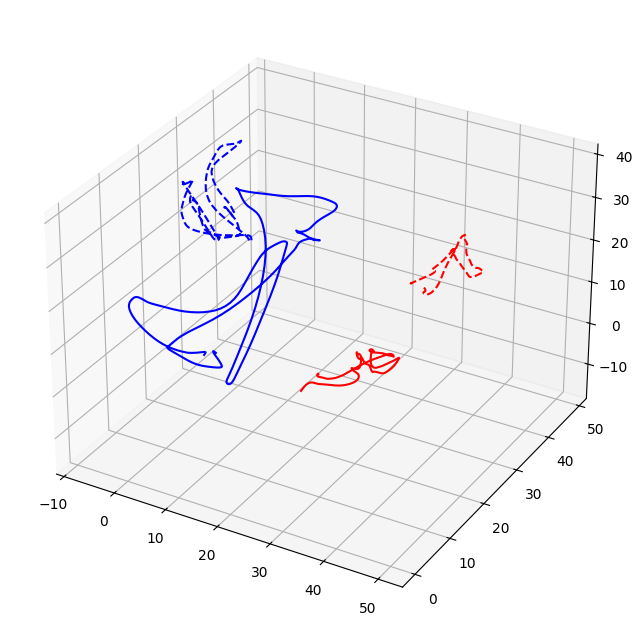

Coupling Score: 0.42867744643596634
Arm Asymmetry: -7651.093615100171


In [15]:

def compute_ArmCoupling(df, keypoints=['Wrist'], dimensions=['x', 'y', 'z'], absolute=True, z=False):
    correlations = []
    
    for kp in keypoints:
        for dim in dimensions:
            if z:
                left_col = f"L{kp}_{dim}_z"
                right_col = f"R{kp}_{dim}_z"
            else:
                left_col = f"L{kp}_{dim}"
                right_col = f"R{kp}_{dim}"
                
            if left_col in df.columns and right_col in df.columns:
                corr = np.corrcoef(df[left_col], df[right_col])[0, 1]  # Pearson correlation
                if absolute:
                    corr = np.abs(corr)
                correlations.append(corr)
    
    return np.nanmean(correlations)  # Average correlation across keypoints and dimensions

def compute_multimovementAssymetry(df, z=False):
    joints = ['elbow_flex', 'wrist_flex', 'wrist_dev']
    
    integral_diff_left = 0
    integral_diff_right = 0
    joint_integral_differences = []

    for joint in joints:
        if z:
            joint_r_speed = f"{joint}_r_speed_z"
            joint_l_speed = f"{joint}_l_speed_z"
        else:
            joint_r_speed = f"{joint}_r_speed"
            joint_l_speed = f"{joint}_l_speed"
            
        if joint_r_speed in df.columns and joint_l_speed in df.columns:
            # Compute the integral of velocity (sum of speed over time) for left and right joints
            integral_velocity_left = np.sum(np.abs(df[joint_l_speed]))  # Sum of absolute speed
            integral_velocity_right = np.sum(np.abs(df[joint_r_speed]))  # Sum of absolute speed

            # Compute the difference in integral of angular velocity between left and right 
            # the more +, the more distance is left is travelling), 
            # but note that because od z-scoring, 0 does not reflect perfect symmetry in distance travelled by both hands
            joint_integral_diff = integral_velocity_left - integral_velocity_right
            joint_integral_differences.append(joint_integral_diff)

            # Accumulate for total integral difference calculation
            integral_diff_left += integral_velocity_left
            integral_diff_right += integral_velocity_right

    # Compute the overall difference in integrated velocities
    total_integral_difference = np.mean(joint_integral_differences)  # Mean of differences across joints

    return {
        'mean_integral_difference': total_integral_difference,
        'joint_integral_differences': joint_integral_differences,
        'total_left_integral_velocity': integral_diff_left,
        'total_right_integral_velocity': integral_diff_right
    }

# Example usage
coupling_score = compute_ArmCoupling(df_sample, keypoints=['Wrist', 'Elbow'], dimensions=['x', 'y', 'z'], z=True)
arm_asymmetry = compute_multimovementAssymetry(df_sample, z=True)

# Plot the trajectories
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

# Plot the left arm
ax.plot3D(df_sample['LWrist_x'], df_sample['LWrist_y'], df_sample['LWrist_z'], 'r')
ax.plot3D(df_sample['LElbow_x'], df_sample['LElbow_y'], df_sample['LElbow_z'], 'r', linestyle='--')

# Plot the right arm
ax.plot3D(df_sample['RWrist_x'], df_sample['RWrist_y'], df_sample['RWrist_z'], 'b')
ax.plot3D(df_sample['RElbow_x'], df_sample['RElbow_y'], df_sample['RElbow_z'], 'b', linestyle='--')

plt.show()

# Print the symmetry score
print("Coupling Score:", coupling_score)
print("Arm Asymmetry:", arm_asymmetry['mean_integral_difference'])

## Intermittency

Intermittency characterizes the 'unsmoothess' of the movement. We follow @pouw_etal21 and computer dimensionless jerk measure (also see @hogan_sternad09 ). This measure is computed as the integral of the second derivative of the speed (i.e., jerk) squared multiplied by the duration cubed over the maximum squared velocity.

In [16]:
#| code-fold: true
#| code-summary: Custom functions

# Function to calculate intermittency (from REF-Wim)
def get_intermittency(jerk_values, speed_values):
    """Calculate the dimensionless smoothness measure using precomputed smoothed jerk and speed."""
    smoothed_jerk = jerk_values
    speed = speed_values
    
    if not np.all(speed == 0):
        integrated_squared_jerk = np.sum(smoothed_jerk ** 2)
        max_squared_speed = np.max(speed ** 2)
        D3 = len(speed) ** 3
        jerk_dimensionless = integrated_squared_jerk * (D3 / max_squared_speed)
        smoothness = jerk_dimensionless
    else:
        smoothness = np.nan

    return smoothness


We can calculate intermittency for kinematics as well as for the joint angles.

In [17]:
#| echo: false

# Calculate on sample
subdf = df_sample
group = 'arm'

# Get the columns that contain group and sum/power (these are cols with aggregated measures)
cols = [col for col in subdf.columns if group in col and 'sum' in col or 'power' in col]

# Calculate intermittency for kinematic measures (from Pose2sim)
speed = subdf[group + "_speedKin_sum_z"].values
jerk = subdf[group + "_jerkKin_sum_z"].values
intermittency_kin = get_intermittency(jerk, speed)
intermittency_kin = np.log(intermittency_kin) # natural log
print('Intermittency, kinematics: ', intermittency_kin)

# Calculate intermittency for inverse kinematic measures (from OpenSim)
speed = subdf[group + "_angSpeed_sum_z"].values
jerk = subdf[group + "_angJerk_sum_z"].values
intermittency_ik = get_intermittency(jerk, speed)
intermittency_ik = np.log(intermittency_ik) # natural log
print('Intermittency, joint angles: ', intermittency_ik)

Intermittency, kinematics:  29.512725544086184
Intermittency, joint angles:  31.333161498897482


## Vowel space area


Vowel space area (VSA) is defined as the are of the quadrilateral formed by the four corner vowels /i/, /a/, /u/ and /ɑ/ in the F1-F2 space. It is a measure of the articulatory 'working' space and researchers often use it to characterize speech motor control (e.g., @berisha_etal14). 

Despite the fact that we are not dealing with speech data, we can still compute VSA for the first two formants. Following Daniel R. McCloy's [tutorial for R](https://drammock.github.io/phonR/), we will compute VSA for the sample timeseries as the area of the convex hull encompassing all tokens.



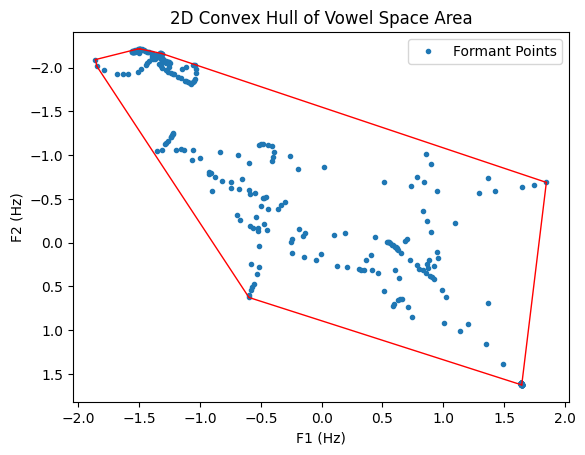

In [18]:
# Function to calculate vocal space area (as a convex hull), REF
def getVSA(f1, f2, plot=False):
   
    # 2d convex hull
    points = np.array([f1, f2]).T
    hull_2d = ConvexHull(points)
    volume_2d = hull_2d.volume
    volume_2d = np.log(volume_2d) # natural log

    if plot:
        plt.figure()
        plt.plot(points[:, 0], points[:, 1], 'o', markersize=3, label='Formant Points')
        
        for simplex in hull_2d.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r-', linewidth=1)
        
        plt.xlabel('F1 (Hz)')
        plt.ylabel('F2 (Hz)')
        plt.gca().invert_yaxis()
        plt.legend()
        plt.title('2D Convex Hull of Vowel Space Area')
        plt.show()
    
    return volume_2d

# Calculate on sample
f1_clean = df_sample['f1_clean_z'].dropna()
f2_clean = df_sample['f2_clean_z'].dropna()
vsa = getVSA(f1_clean, f2_clean, plot=True)

## Motor complexity

As a part of exploratory analysis, we also want to assess the motor complexity of the movements as a proxy of coordinative - therefore cognitive - effort relating to the signal.

Using OpenSim, we have been able to extract joint angle measurements for our data. We can use them to assess a motor complexity or alternatively, motor performance of a participant's movements. We will use Principal Component Analysis (PCA) to assess the motor complexity. We will look at the number of principal components that explain a certain amount of variance in the data and the slope of the explained variance. This will give us a measure of how many (uncorrelated) dimensions/modes cover the most (80 or 95%) of the features of a signal, therefore how complex the movement is in terms of its coordination patterns (see for instance @daffertshofer_etal04a, @yan_etal20).


In [75]:
df_sample1 = pd.read_csv(filestotrack[21])
df_sample2 = pd.read_csv(filestotrack[11])

In [85]:
filestotrack[11]

'e:\\FLESH_ContinuousBodilyEffort\\07_TS_featureExtraction\\..\\05_finalMerge\\TS_final\\merged_anno_0_1_23_p0.csv'

In [40]:
df_sample

'e:\\FLESH_ContinuousBodilyEffort\\07_TS_featureExtraction\\..\\05_finalMerge\\TS_final\\merged_anno_0_1_35_p1.csv'

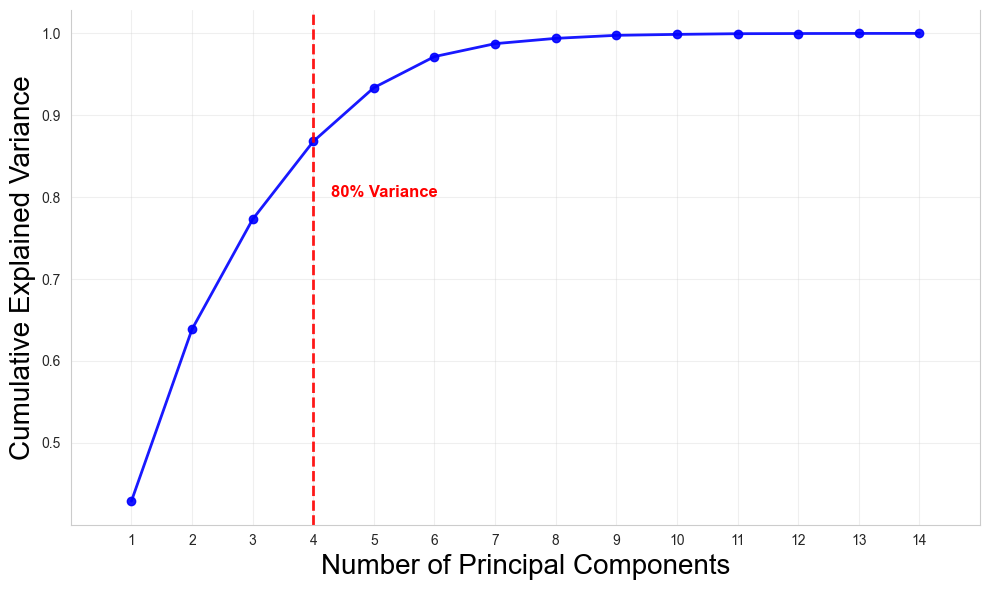

PCA for arm movement complexity (4, 0.1464112557691898, 6, 0.10857451927663701)


<Figure size 640x480 with 0 Axes>

In [79]:
# Function to get the PCA
def get_PCA(df, plot=False):
    # Step 1: Standardize the Data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df)
    
    # Step 2: Apply PCA
    pca = PCA()
    pca.fit(standardized_data)
    
    # Step 3: Explained Variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance.cumsum()

    # Step 4: Find the number of components that explain 95% variance
    n_components_for_80_variance = np.argmax(cumulative_explained_variance >= 0.8) + 1
    
    # Step 5: Compute the slope for the first n_components_for_95_variance
    if n_components_for_80_variance > 1:
        slope_80 = (cumulative_explained_variance[n_components_for_80_variance-1] - cumulative_explained_variance[0]) / (n_components_for_80_variance - 1)
    else:
        slope_80 = cumulative_explained_variance[0]  # Only one component case

    # 95% variance
    n_components_for_95_variance = np.argmax(cumulative_explained_variance >= 0.95) + 1
    
    # Step 5: Compute the slope for the first n_components_for_95_variance
    if n_components_for_95_variance > 1:
        slope_95 = (cumulative_explained_variance[n_components_for_95_variance-1] - cumulative_explained_variance[0]) / (n_components_for_95_variance - 1)
    else:
        slope_95 = cumulative_explained_variance[0]  # Only one component case


    # Set Seaborn style for consistency
    sns.set_style("whitegrid")  

    main_color = "black"   # Black for main cumulative variance line
    red_color = "red"      # Basic red for 80% variance threshold
    blue_color = "blue"    # Basic blue for 95% variance threshold

    if plot:
        plt.figure(figsize=(10, 6))

        # get rid of the grid
        plt.grid(False)

        # gwt rid of the lines in the backroug
        plt.gca().spines['top'].set_visible(False)
        
        # Adjust x-axis indexing: Components start from 1, not 0
        x_values = range(1, len(cumulative_explained_variance) + 1)
        
        # Plot cumulative explained variance (black line with markers)
        plt.plot(x_values, cumulative_explained_variance, marker='o', linestyle='-', markersize=6, linewidth=2, color=blue_color, alpha=0.9, label='Cumulative Explained Variance')
        
        # Add vertical dashed lines for 80% and 95% variance thresholds
        plt.axvline(x=n_components_for_80_variance, color=red_color, linestyle='--', 
                    linewidth=2, alpha=0.9)
        
        # plt.axvline(x=n_components_for_95_variance, color=blue_color, linestyle='--', 
        #             linewidth=2, alpha=0.9)

        # Labels for variance thresholds on the graph
        plt.text(n_components_for_80_variance + 0.3, 0.8, "80% Variance", 
                color=red_color, fontsize=12, fontweight='bold')
        
        # plt.text(n_components_for_95_variance + 0.3, 0.95, "95% Variance", 
        #         color=blue_color, fontsize=12, fontweight='bold')

        # Labels and title
        plt.xlabel('Number of Principal Components', fontsize=20, color='black')
        plt.ylabel('Cumulative Explained Variance', fontsize=20, color='black')
        #plt.title('Cumulative Explained Variance by PCA', fontsize=16, color='black')
        
        # Ensure x-axis starts at 1 and labels are correctly spaced
        plt.xticks(x_values)  # Explicitly setting x-ticks
        
        # Subtle grid
        plt.grid(True, alpha=0.3)  
        
        # Tight layout and saving for consistency
        plt.tight_layout()

        #xlim
        plt.xlim(0, len(cumulative_explained_variance) +1)  # Adjust x-axis limits
    
        plt.show()
        plt.savefig("MUSCLE_plot_pca_ges2.png", dpi=300)  # Match other plots
        #plt.close()

    return n_components_for_80_variance, slope_80, n_components_for_95_variance, slope_95

# Calculate on sample
PCAcolls_all = ['pelvis_tilt_z', 'pelvis_list_z', 'pelvis_rotation_z', 'pelvis_tx_z',
       'pelvis_ty_z', 'pelvis_tz_z', 'hip_flexion_r_z', 'hip_adduction_r_z',
       'hip_rotation_r_z', 'knee_angle_r_z', 'knee_angle_r_beta_z', 'ankle_angle_r_z',
       'subtalar_angle_r_z', 'hip_flexion_l_z', 'hip_adduction_l_z',
       'hip_rotation_l_z', 'knee_angle_l_z', 'knee_angle_l_beta_z', 'ankle_angle_l_z',
       'subtalar_angle_l_z', 'L5_S1_Flex_Ext_z', 'L5_S1_Lat_Bending_z',
       'L5_S1_axial_rotation_z', 'L4_L5_Flex_Ext_z', 'L4_L5_Lat_Bending_z',
       'L4_L5_axial_rotation_z', 'L3_L4_Flex_Ext_z', 'L3_L4_Lat_Bending_z',
       'L3_L4_axial_rotation_z', 'L2_L3_Flex_Ext_z', 'L2_L3_Lat_Bending_z',
       'L2_L3_axial_rotation_z', 'L1_L2_Flex_Ext_z', 'L1_L2_Lat_Bending_z',
       'L1_L2_axial_rotation_z', 'L1_T12_Flex_Ext_z', 'L1_T12_Lat_Bending_z',
       'L1_T12_axial_rotation_z', 'neck_flexion_z', 'neck_bending_z',
       'neck_rotation_z', 'arm_flex_r_z', 'arm_add_r_z', 'arm_rot_r_z', 'elbow_flex_r_z',
       'pro_sup_r_z', 'wrist_flex_r_z', 'wrist_dev_r_z', 'arm_flex_l_z', 'arm_add_l_z',
       'arm_rot_l_z', 'elbow_flex_l_z', 'pro_sup_l_z', 'wrist_flex_l_z',
       'wrist_dev_l_z']

PCAcolls_arm = ['arm_flex_r_z', 'arm_add_r_z', 'arm_rot_r_z', 'elbow_flex_r_z', 'pro_sup_r_z',
       'wrist_flex_r_z', 'wrist_dev_r_z', 'arm_flex_l_z', 'arm_add_l_z', 'arm_rot_l_z',
       'elbow_flex_l_z', 'pro_sup_l_z', 'wrist_flex_l_z', 'wrist_dev_l_z']

# make also list wihout _z
PCAcolls_arm_plot = [col.replace('_z', '') for col in PCAcolls_arm]


# Calculate PCA for all
# subdf = df_sample
# PCA_all = get_PCA(subdf[PCAcolls_all], plot=True)
# print('PCA for whole-body movement complexity', PCA_all)

# Calculate PCA for arms
subdf = df_sample1
PCA_arms = get_PCA(subdf[PCAcolls_arm_plot], plot=True)
print('PCA for arm movement complexity', PCA_arms)


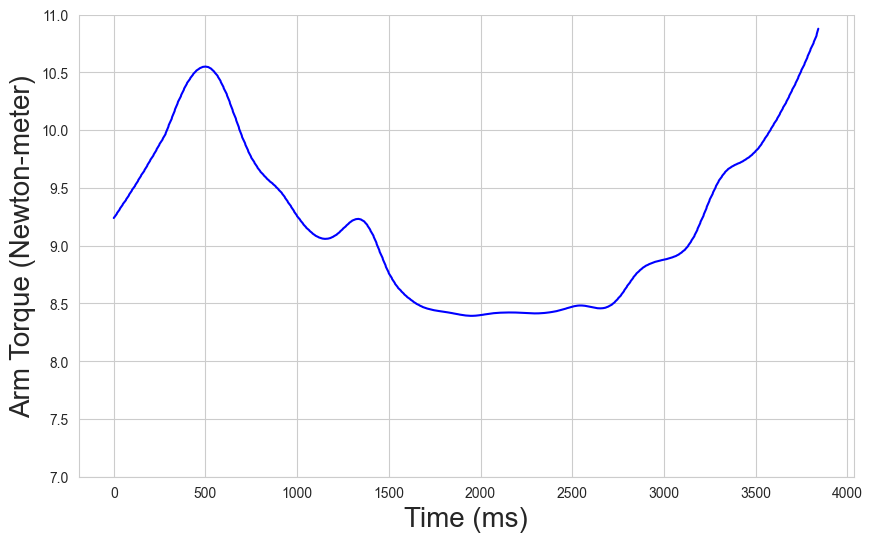

In [84]:
# for df_sample, plot arm_torque_sum

plt.figure(figsize=(10, 6))
plt.gca().spines['top'].set_visible(False)

plt.plot(df_sample2['time'], df_sample2['arm_moment_sum'], label='Arm Torque Sum', color='blue')
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Arm Torque (Newton-meter)', fontsize=20)

plt.ylim(7, 11)

# save it with dpi 300
plt.savefig("MUSCLE_plot_arm_torque_sum_ges1.png", dpi=300)
plt.show()


# Extracting features for all trials

Now we will loop through each file (representing a trial), extract the features, add all necessary metadata and save each trial in a overall dataframe. Before any feature is collected, we min-max normalize all data to get to relative feature of effort per participant


In [21]:
import warnings
warnings.filterwarnings("ignore")

# Initialize the dataframe
features_df = pd.DataFrame()

##########################
##### preparations #######
##########################

# These are the names of the columns with movement annotations
movcols = ['upper_mov', 'arms_mov', 'lower_mov', 'head_mov']

# These are our four dimensions for which we have aggregated movement data
groups = ['arm', 'lowerbody', 'leg', 'head']

# Mapping between dimension and annotation column
movcol_keys = {'arm': 'arms_mov', 'lowerbody': 'lower_mov', 'leg': 'lower_mov', 'head': 'head_mov', 'upperbody': 'upper_mov'}

# These are groups for BBMV
kp_arms = ['RWrist', 'RElbow', 'RShoulder', 'LWrist', 'LElbow', 'LShoulder']
kp_lower = ['RAnkle', 'RKnee', 'LAnkle', 'LKnee']
kp_legs = ['RAnkle', 'RKnee', 'LAnkle', 'LKnee']
kp_head = ['Head']
kp_keys = {'arm': kp_arms, 'lowerbody': kp_lower, 'leg': kp_legs, 'head': kp_head}

# These are cols associated with balance
balancecols = ['COPc', 'spine_moment_sum', 'pelvis_moment_sum', 'spine_moment_sum_change', 'pelvis_moment_sum_change']

# These are cols associated with acoustics
voccols = ['envelope', 'envelope_change', 'f0', 'f1_clean', 'f1_clean_vel', 'f2_clean', 'f2_clean_vel', 'f3_clean', 'f3_clean_vel', 'CoG']

PCAcolls_all = ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'pelvis_tx',
       'pelvis_ty', 'pelvis_tz', 'hip_flexion_r', 'hip_adduction_r',
       'hip_rotation_r', 'knee_angle_r', 'knee_angle_r_beta', 'ankle_angle_r',
       'subtalar_angle_r', 'hip_flexion_l', 'hip_adduction_l',
       'hip_rotation_l', 'knee_angle_l', 'knee_angle_l_beta', 'ankle_angle_l',
       'subtalar_angle_l', 'L5_S1_Flex_Ext', 'L5_S1_Lat_Bending',
       'L5_S1_axial_rotation', 'L4_L5_Flex_Ext', 'L4_L5_Lat_Bending',
       'L4_L5_axial_rotation', 'L3_L4_Flex_Ext', 'L3_L4_Lat_Bending',
       'L3_L4_axial_rotation', 'L2_L3_Flex_Ext', 'L2_L3_Lat_Bending',
       'L2_L3_axial_rotation', 'L1_L2_Flex_Ext', 'L1_L2_Lat_Bending',
       'L1_L2_axial_rotation', 'L1_T12_Flex_Ext', 'L1_T12_Lat_Bending',
       'L1_T12_axial_rotation', 'neck_flexion', 'neck_bending',
       'neck_rotation', 'arm_flex_r', 'arm_add_r', 'arm_rot_r', 'elbow_flex_r',
       'pro_sup_r', 'wrist_flex_r', 'wrist_dev_r', 'arm_flex_l', 'arm_add_l',
       'arm_rot_l', 'elbow_flex_l', 'pro_sup_l', 'wrist_flex_l',
       'wrist_dev_l']

PCAcolls_arm = ['arm_flex_r', 'arm_add_r', 'arm_rot_r', 'elbow_flex_r', 'pro_sup_r',
       'wrist_flex_r', 'wrist_dev_r', 'arm_flex_l', 'arm_add_l', 'arm_rot_l',
       'elbow_flex_l', 'pro_sup_l', 'wrist_flex_l', 'wrist_dev_l']


##########################
####### main loop ########
##########################

for file in files_part2:
    print('working on file: ', file)
    df = pd.read_csv(file)

    # Get metadata
    df["concept"] = df["FileInfo"].apply(lambda x: x.split("_")[1])
    df["modality"] = df["FileInfo"].apply(lambda x: x.split("_")[2])
    df["correction"] = df["FileInfo"].apply(lambda x: x.split("_")[3])
    df.drop(columns=["FileInfo"], inplace=True)

    ######################################
    ############## zscoring ##############
    ######################################
    
    # Get all numerical cols
    numcols = df.select_dtypes(include=[np.number]).columns
    numcols = [x for x in numcols if x != 'time']           # not time

    trialID = df['TrialID'][0]
    pcnID = trialID.split('_')[0] + '_' + trialID.split('_')[-1]

    normalized_cols = {}

    for col in numcols:
        mean, std = zscore_dict[pcnID + "_" + col]
        normalized_cols[col] = df[col].apply(lambda x: (x - mean) / std)

    df_normed = pd.DataFrame(normalized_cols)


    # get all cols that are in df but not numcols
    nonnumcols = [x for x in df.columns if x not in numcols]

    # add them to the normalized df
    for col in nonnumcols:
        df_normed[col] = df[col]

    ##########################
    ##### movement feat ######
    ##########################

    # Look only into portion of the data where is movement
    subdf = pd.DataFrame()
    subdf = df_normed[df_normed["movement_in_trial"] == "movement"]
    subdf = subdf.reset_index(drop=True)

    if subdf.shape[0] > 0:
        duration_mov = subdf["time"].iloc[-1] - subdf["time"].iloc[0] # duration
        submovcols = [col for col in movcols if subdf[col].values[0] == "movement"]
        numofArt = len(submovcols)  # number of articulators

        # Prepare dictionary to store the values
        body_sumfeat = {}

        # Loop over our four dimensions-groups and collect features
        for group in groups:

            subsubdf = pd.DataFrame()
            subsubdf = subdf[subdf[movcol_keys[group]] == "movement"]
            subsubdf = subsubdf.reset_index(drop=True)

            # If there is no movement, we set lal values to 0 and continue
            if subsubdf.shape[0] == 0:
                body_sumfeat_row = pd.DataFrame()
                body_sumfeat_row["duration_group"] = 0
                continue
            else:
                # Get the columns that contain group and sum/power (these are cols with aggregated measures)
                cols = [col for col in subsubdf.columns if group in col and 'sum' in col or 'power' in col]
                duration_group = subsubdf["time"].iloc[-1] - subsubdf["time"].iloc[0] # duration
            
                # Get statistics
                body_sumfeat = get_statistics(cols, df_normed, subsubdf, body_sumfeat, df_means)
                body_sumfeat[group + "_duration"] = duration_group
    
                # Calculate intermittency for kinematic measures (from Pose2sim)
                speed = subsubdf[group + "_speedKin_sum"].values
                jerk = subsubdf[group + "_jerkKin_sum"].values
                intermittency = get_intermittency(jerk, speed)
                intermittency = np.log(intermittency) # natural log
                body_sumfeat[group + "_inter_Kin"] = intermittency

                # Calculate intermittency for inverse kinematic measures (from OpenSim)
                speed = subsubdf[group + "_angSpeed_sum"].values
                jerk = subsubdf[group + "_angJerk_sum"].values
                intermittency = get_intermittency(jerk, speed)
                intermittency = np.log(intermittency) # natural log
                body_sumfeat[group + "_inter_IK"] = intermittency
                
                # Get bounding box of movement volume (BBMV)
                bbmv_sum = get_bbmv(subsubdf, group, kp_keys)          
                body_sumfeat[group + "_bbmv"] = bbmv_sum
            
    else:
        duration_mov = 0
        numofArt = 0
        body_sumfeat = {}

    # Convert dictionary to dataframe
    body_sumfeat_row = pd.DataFrame({key: [value] for key, value in body_sumfeat.items()})

    # Adapt
    body_sumfeat_row = adapt_row(body_sumfeat_row)

    # Add duration and numofArt
    body_sumfeat_row['duration_mov'] = duration_mov
    body_sumfeat_row['numofArt'] = numofArt

    # Get BBMV for the whole body (so concatenate all the groups)
    bbmv_total = body_sumfeat_row[[col for col in body_sumfeat_row.columns if 'bbmv' in col and 'rate' not in col]].sum(axis=1)
    body_sumfeat_row['bbmv_total'] = bbmv_total

    ####################
    ###### balance #####
    ####################

    subdf = pd.DataFrame()
    subdf = df_normed[df_normed["movement_in_trial"] == "movement"]
    subdf = subdf.reset_index(drop=True)

    # Collect features (note that here we collect features for the segment of the general movement, i.e., movement of any body part)
    balance_sumfeat = {}
    balance_sumfeat = get_statistics(balancecols, df_normed, subdf, balance_sumfeat, df_means)

    # Convert dictionary to dataframe
    balance_sumfeat_row = pd.DataFrame({key: [value] for key, value in balance_sumfeat.items()})

    # Adapt
    balance_sumfeat_row = adapt_row(balance_sumfeat_row)

    ####################
    #### acoustics #####
    ####################

    # Check if vocalization exists
    if "vocalization" not in df_normed.columns:
        print("No vocalization column in the dataframe")
        vocfeat_row = pd.DataFrame() # empty row
    else:
        # Collect features only for the time of vocalizing
        subdf = pd.DataFrame()
        subdf = df_normed[df_normed["vocalization"] == "sounding"] 
        subdf = subdf.reset_index(drop=True)

        if subdf.shape[0] > 0:
            duration_voc = subdf["time"].iloc[-1] - subdf["time"].iloc[0] # duration

            # Collect features
            vocfeat_dict = {}
            vocfeat_dict = get_statistics(voccols, df_normed, subdf, vocfeat_dict, df_means)


        else:
            print("No vocalization in the trial")
            vocfeat_dict = {}
            duration_voc = 0

        # Convert dictionary to dataframe
        vocfeat_row = pd.DataFrame({key: [value] for key, value in vocfeat_dict.items()})

        # Adapt
        vocfeat_row = adapt_row(vocfeat_row)

        # Append duration
        vocfeat_row['duration_voc'] = duration_voc

        # If f1-f3 are not only nan, calculate the volume of the convex hull (i.e., vowel space area)
        if subdf['f1_clean'].isnull().all() and subdf['f2_clean'].isnull().all():
            print("No f1, f2 in the dataframe")
            vocfeat_row['VSA_f1f2'] = 0
        else:
            f1_clean = subdf['f1_clean'].dropna()
            f2_clean = subdf['f2_clean'].dropna()
            VSA2d = getVSA(f1_clean, f2_clean) # get VSA
            vocfeat_row['VSA_f1f2'] = VSA2d

    # Concatenate the rows for movement, balance, and acoustics
    newrow_concat = pd.concat([body_sumfeat_row, balance_sumfeat_row, vocfeat_row], axis=1)

    ###################################
    ###### arms submovements ##########
    ###################################
   
    # Take only the chunk where arms are moving
    subdf = pd.DataFrame()
    subdf = df_normed[df_normed["arms_mov"] == "movement"]
    subdf = subdf.reset_index(drop=True)

    # Prepare an empty row to store the features
    newrow_arms = pd.DataFrame()

    if subdf.shape[0] == 0:
        print("No movement in arms")
        arms_submov = 0 # number of submovements   
        wrists_tempVar = 0 # temporal variability
    else:
        # Count submovements in wrist
        submovcols = [col for col in subdf.columns if "Wrist" in col and 'speed' in col]
        arms_submov = []
        wrists_tempVar = []
        for col in submovcols:
            # Calculate the number of peaks that delimit unique submovements
            ts_mean = df_means[col + '_z_general_mean'].values[0] # get the overall mean of this signal
            height = ts_mean - df_means[col + '_z_general_std'].values[0] # height is mean - 1*std
            peaks, _ = find_peaks(subdf[col], height=height, distance=150)
            arms_submov.append(len(peaks))
            
            # Calculate the temporal variability of the submovements
            peak_times = df_normed.loc[peaks, "time"]
            intervals = np.diff(peak_times)
            tempVar = np.std(intervals)
            wrists_tempVar.append(tempVar)

    # Append to the row
    newrow_arms['arms_submovements'] = [arms_submov]
    newrow_arms['Wrist_tempVar'] = [wrists_tempVar]

    ###################################
    ######### arm symmetry ############
    ###################################

    # Calculate symmetry for arms
    symmetry_score = compute_ArmCoupling(subdf, keypoints=['Wrist', 'Elbow'], dimensions=['x', 'y', 'z'])
    arm_asymmetry = compute_multimovementAssymetry(subdf)
    newrow_arms['arm_coupling'] = symmetry_score
    newrow_arms['arm_asymmetry'] = arm_asymmetry['mean_integral_difference']


    ###################################
    ###### Motor complexity (PCA) #####
    ###################################

    # Whole-body complexity    
    subdf = pd.DataFrame()          
    subdf = df_normed.loc[df_normed['movement_in_trial'] == 'movement']
    subdf = subdf.reset_index(drop=True)

    if subdf.shape[0] == 0:
        body_nComp_80 = 0
        body_slope_80 = 0
        body_nComp_95 = 0
        body_slope_95 = 0
    else:
        bodydf = subdf.loc[:, PCAcolls_all]
        body_nComp_80, body_slope_80, body_nComp_95, body_slope_95 = get_PCA(bodydf)

    # Append to the row
    newrow_concat['body_nComp_80'] = body_nComp_80
    newrow_concat['body_slope_80'] = body_slope_80
    newrow_concat['body_nComp_95'] = body_nComp_95
    newrow_concat['body_slope_95'] = body_slope_95

    # Arm complexity
    # Empty subdf
    subdf = pd.DataFrame()
    subdf = df_normed.loc[df_normed['arms_mov'] == 'movement']
    if subdf.shape[0] == 0:
        arm_nComp_80 = 0
        arm_slope_80 = 0
        arm_nComp_95 = 0
        arm_slope_95 = 0
    else:
        armdf = subdf.loc[:, PCAcolls_arm]
        arm_nComp_80, arm_slope_80, arm_nComp_95, arm_slope_95 = get_PCA(armdf)

    # Append to the row
    newrow_concat['arm_nComp_80'] = arm_nComp_80
    newrow_concat['arm_slope_80'] = arm_slope_80
    newrow_concat['arm_nComp_95'] = arm_nComp_95
    newrow_concat['arm_slope_95'] = arm_slope_95


    # Concatenate newrow and newrow_arms
    newrow_final = pd.concat([newrow_concat, newrow_arms], axis=1)

    # Add metadata
    newrow_final["TrialID"] = df_normed["TrialID"].values[0]
    newrow_final["concept"] = df_normed["concept"].values[0]
    newrow_final["modality"] = df_normed["modality"].values[0]
    newrow_final["correction"] = df_normed["correction"].values[0]

    # Add the row the the overal df
    features_df = pd.concat([features_df, newrow_final], ignore_index=True)

    ###################################
    ########### Answer info ###########
    ###################################

    index = int(df_normed["TrialID"].values[0].split("_")[2])
    concept = df_normed["concept"].values[0]

    # Check what was the answer and cosine similarity for the index
    answer_fol = similaritydata[similaritydata["index"] == index]["answer"].values[0]
    answer_fol_sim = similaritydata[similaritydata["index"] == index]["cosine_similarity"].values[0]

    # Check what was the answer and cosine similarity for index before - but only if the previous index has the same concept as the current one
    if index - 1 in similaritydata["index"].values and similaritydata[similaritydata["index"] == index - 1]["word"].values[0] == concept:
        answer_prev = similaritydata[similaritydata["index"] == index - 1]["answer"].values[0]
        answer_prev_sim = similaritydata[similaritydata["index"] == index - 1]["cosine_similarity"].values[0]
    else:
        #print("previous index doesn't have the same concept")
        answer_prev = None
        answer_prev_sim = None

    # Append to the features_df
    features_df.loc[features_df["TrialID"] == df_normed["TrialID"].values[0], "answer_fol"] = answer_fol
    features_df.loc[features_df["TrialID"] == df_normed["TrialID"].values[0], "answer_fol_dist"] = answer_fol_sim
    features_df.loc[features_df["TrialID"] == df_normed["TrialID"].values[0], "answer_prev"] = answer_prev
    features_df.loc[features_df["TrialID"] == df_normed["TrialID"].values[0], "answer_prev_dist"] = answer_prev_sim

    # Check what is the expressibility for the concept & modality
    express = express_df[(express_df["word"] == concept) & (express_df["modality"] == df_normed["modality"].values[0])]["fit"].values[0]
    features_df.loc[features_df["TrialID"] == df_normed["TrialID"].values[0], "expressibility"] = express

    # Add response time from answerdata
    response_time = answerdata[answerdata["TrialID"] == df_normed["TrialID"].values[0]]["response_time_sec"].values[0]
    features_df.loc[features_df["TrialID"] == df_normed["TrialID"].values[0], "response_time_sec"] = response_time

# Create a concept id to group together corrections of one concept
for row in features_df.iterrows():
    row = row[1]
    features_df.loc[row.name, "concept_id"] = row["concept"] + "_" + row["modality"] + "_" + row["TrialID"].split("_")[-1]

# Get rid of columns that have only NA values
features_df = features_df.dropna(axis=1, how='all')

# Round all num cols to 3
numcols = features_df.select_dtypes(include=[np.number]).columns
features_df[numcols] = features_df[numcols].round(3)





working on file:  e:\FLESH_ContinuousBodilyEffort\07_TS_featureExtraction\..\05_finalMerge\TS_final\merged_anno_0_2_23_p1.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\07_TS_featureExtraction\..\05_finalMerge\TS_final\merged_anno_0_2_24_p1.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\07_TS_featureExtraction\..\05_finalMerge\TS_final\merged_anno_0_2_25_p1.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\07_TS_featureExtraction\..\05_finalMerge\TS_final\merged_anno_0_2_26_p1.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\07_TS_featureExtraction\..\05_finalMerge\TS_final\merged_anno_0_2_27_p1.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\07_TS_featureExtraction\..\05_finalMerge\TS_final\merged_anno_0_2_28_p1.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\07_TS_featureExtraction\..\05_finalMerge\TS_final\merged_anno_0_2_29_p1.csv
No movement in arms
working on file:  e:\FLESH_ContinuousBodilyEffort\07_TS_featureExtraction\..\05_finalMerge\TS_fina

In [22]:
#| echo: false

features_df.head(50)

arm_duration  arm_inter_Kin  arm_inter_IK  arm_bbmv  lowerbody_duration  \
0         3988.0         26.197        26.728     8.472              2020.0   
1         3868.0         26.674        28.122     8.148              2870.0   
2         4014.0         26.449        27.565     8.465               874.0   
3         4046.0         26.207        28.558     8.482              3750.0   
4         4708.0         26.502        28.717     8.309              4508.0   
5         4004.0         26.978        28.554     8.699              3598.0   
6            NaN            NaN           NaN       NaN               784.0   
7         5248.0         28.973        31.658    10.919              4930.0   
8         1784.0         25.011        24.190     6.604                 NaN   
9         1284.0         24.278        24.516     5.054              1334.0   
10        1494.0         24.248        24.502     6.483              2944.0   
11        2486.0         25.718        26.035     6.420               780.0   
12        2968.0         25.494        28.758     8.040              2750.0   
13        3850.0         27.666        27.348     7.419              3366.0   
14        3236.0         26.551        27.446     6.411                 NaN   
15        5572.0         28.818        28.100     9.814              5158.0   
16        1144.0         23.839        26.291     8.156               324.0   
17        3816.0         28.001        29.471    10.348              3244.0   
18        5280.0         28.098        30.942    13.350              5862.0   
19        4302.0         28.401        31.164    10.572              4206.0   
20        4474.0         27.316        30.376    10.229              4398.0   
21        4388.0         27.872        31.225     9.748              3782.0   
22        5852.0         29.417        32.048    10.675              5404.0   
23        2736.0         26.324        27.656     6.547                 NaN   
24        4256.0         28.675        29.776     8.148                 NaN   
25        2516.0         26.234        27.815     7.774               884.0   
26        5832.0         29.027        31.043    11.094              3936.0   
27        4504.0         28.604        30.892     9.939              4266.0   
28        5946.0         28.473        30.925     9.779              5136.0   
29        6100.0         29.300        31.243    10.521              6030.0   
30        3004.0         26.079        26.368     7.253              2686.0   
31        3918.0         28.358        28.936     8.394              3366.0   
32        3918.0         28.120        29.766     9.343              1692.0   
33        1202.0         23.839        27.274     8.980              1590.0   
34        2352.0         25.612        25.352     6.061                 NaN   
35        1954.0         25.071        25.036     6.560              1992.0   
36        4400.0         27.535        28.492     5.513                 NaN   
37        5726.0         28.953        29.493     7.501              3038.0   
38        4310.0         27.565        28.136     6.982               626.0   
39        2234.0         25.175        26.736     6.535                 NaN   
40        4428.0         28.941        30.742     7.973              2740.0   
41           NaN            NaN           NaN       NaN                 NaN   
42           NaN            NaN           NaN       NaN                 NaN   
43        4032.0         26.813        29.551     7.986                 NaN   
44           NaN            NaN           NaN       NaN                 NaN   
45           NaN            NaN           NaN       NaN                 NaN   
46           NaN            NaN           NaN       NaN                 NaN   
47        3306.0         27.175        28.826     6.781                 NaN   
48        5244.0         28.767        30.137     9.125              4234.0   
49           NaN            NaN           NaN       Na

Before saving it, we also want to see which trials underwent which corrections. Some trials were guessed on first try (only_c0), some after first correction (c0_c1) and some only after second correction or not at all (all_c).


In [23]:
# Identify how are which trials corrected
c0 = features_df[features_df["correction"] == "c0"]["concept_id"].unique()
c1 = features_df[features_df["correction"] == "c1"]["concept_id"].unique()
c2 = features_df[features_df["correction"] == "c2"]["concept_id"].unique()

only_c0 = [x for x in c0 if x not in c1 and x not in c2] # Guessed on first try
c0_c1 = [x for x in c0 if x in c1 and x not in c2] # Guessed on second try
all_c = [x for x in c0 if x in c1 and x in c2] # Guessed on third try or never

# Check whether we have some data that are outside of these three categories (could be that we lost some trials in the processing pipeline)
all = features_df["concept_id"].unique()
missing = [x for x in all if x not in only_c0 and x not in c0_c1 and x not in all_c]
print("Missing: ", missing) # Currently we miss no trials 

# Add column correction_info to features_df
features_df["correction_info"] = features_df["correction"]

# If the concept_id is in only_c0, then correction_info is c0_only
features_df.loc[features_df["concept_id"].isin(only_c0), "correction_info"] = "c0_only"

# Save it
features_df.to_csv(datafolder + "features_df_final.csv", index=False)


Missing:  []


We will be also dealing with some loss of the data because some features was not possible to extract. Let's see for which features it's the most of the data

In [24]:
#| echo: false

# Which of the columns have more than 50% of missing values
missing_values = features_df.isnull().mean()
missing_values = missing_values[missing_values > 0.5]

# Print missing values completely
print(missing_values)


lowerbody_power_pospeak_mean                0.523077
lowerbody_moment_sum_change_pospeak_mean    0.584615
lowerbody_moment_sum_change_pospeak_std     0.846154
lowerbody_speedKin_sum_pospeak_std          0.507692
lowerbody_accKin_sum_pospeak_std            0.507692
lowerbody_angSpeed_sum_pospeak_mean         0.507692
lowerbody_angSpeed_sum_pospeak_std          0.661538
lowerbody_angAcc_sum_pospeak_mean           0.507692
lowerbody_angAcc_sum_pospeak_std            0.661538
lowerbody_angJerk_sum_pospeak_std           0.523077
leg_moment_sum_pospeak_std                  0.507692
leg_moment_sum_change_pospeak_mean          0.600000
leg_angSpeed_sum_pospeak_std                0.569231
leg_angAcc_sum_pospeak_std                  0.569231
head_moment_sum_change_pospeak_std          0.523077
f0_Gmean                                    0.769231
f0_Gstd                                     0.769231
f0_integral                                 0.969231
f0_range                                    0.

Let's also have a first look on the distribution of our three measures of interest - arm moment (torque), COPc, and envelope.

In [27]:
features_df

arm_duration  arm_inter_Kin  arm_inter_IK  arm_bbmv  lowerbody_duration  \
0         3988.0         26.197        26.728     8.472              2020.0   
1         3868.0         26.674        28.122     8.148              2870.0   
2         4014.0         26.449        27.565     8.465               874.0   
3         4046.0         26.207        28.558     8.482              3750.0   
4         4708.0         26.502        28.717     8.309              4508.0   
..           ...            ...           ...       ...                 ...   
60        1906.0         24.668        27.397     8.964              1544.0   
61        1656.0         24.618        27.481     8.746              1196.0   
62           NaN            NaN           NaN       NaN              2914.0   
63           NaN            NaN           NaN       NaN              2188.0   
64           NaN            NaN           NaN       NaN               424.0   

    lowerbody_inter_Kin  lowerbody_inter_IK  lowerbody_bbmv  leg_duration  \
0                26.580              26.181           5.400        2020.0   
1                28.319              28.291           6.487        2870.0   
2                23.434              23.040           2.861         874.0   
3                28.421              28.796           6.124        3750.0   
4                29.760              28.762           6.005        4508.0   
..                  ...                 ...             ...           ...   
60               25.571              28.494           9.252        1544.0   
61               24.525              24.191           9.145        1196.0   
62               28.223              28.352           6.307        2914.0   
63               26.705              26.436           5.167        2188.0   
64               20.744              22.465           1.525         424.0   

    leg_inter_Kin  ...  f1_clean_pospeak_std  f1_clean_vel_pospeak_std  \
0          26.759  ...                   NaN                       NaN   
1          27.096  ...                   NaN                       NaN   
2          22.945  ...                   NaN                       NaN   
3          27.973  ...                   NaN                       NaN   
4          28.679  ...                   NaN                       NaN   
..            ...  ...                   ...                       ...   
60         24.601  ...                 1.247                     0.033   
61         23.606  ...                   NaN                       NaN   
62         27.509  ...                   NaN                     0.383   
63         26.710  ...                   NaN                     0.182   
64         20.486  ...                   NaN                       NaN   

    CoG_Gmean  CoG_Gstd  CoG_pospeak_mean  CoG_pospeak_std  CoG_integral  \
0         NaN       NaN               NaN              NaN           NaN   
1         NaN       NaN               NaN              NaN           NaN   
2         NaN       NaN               NaN              NaN           NaN   
3         NaN       NaN               NaN              NaN           NaN   
4         NaN       NaN               NaN              NaN           NaN   
..        ...       ...               ...              ...           ...   
60        NaN       NaN               NaN              NaN           NaN   
61     -2.953     0.428             1.338              NaN     -1237.758   
62        NaN       NaN               NaN              NaN           NaN   
63        NaN       NaN               NaN              NaN           NaN   
64        NaN       NaN               NaN              NaN           NaN   

    CoG_range            concept_id correction_info  
0         NaN   groot_combinatie_p1              c0  
1         NaN   groot_combinatie_p1              c1  
2         NaN   groot_combinatie_p1              c2  
3         NaN    hoog_combinatie_p1              c0  
4         NaN    hoog_combinatie_p1              c1  
..  

These are for the features in cummulative form (integral)

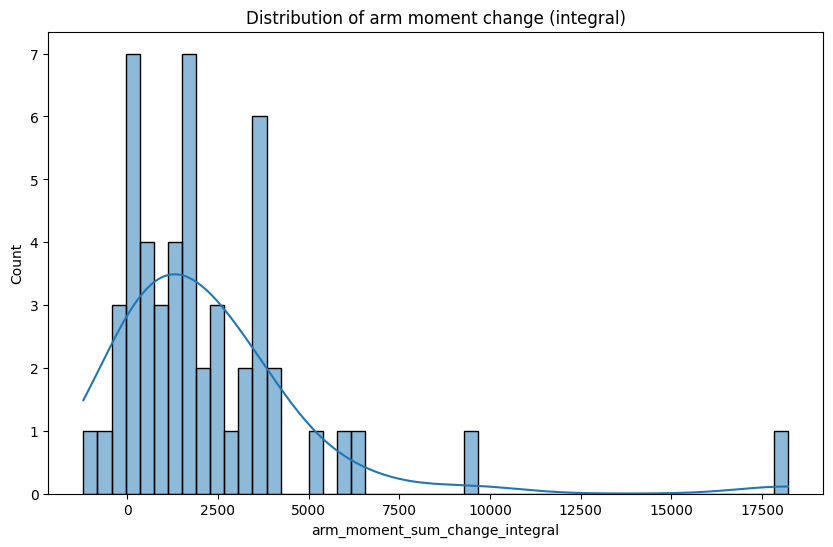

In [ ]:
#| echo: false

plt.figure(figsize=(10, 6))
sns.histplot(data=features_df, x='arm_moment_sum_change_integral', bins=50, kde=True)
plt.title('Distribution of arm moment change (integral)')
plt.show()

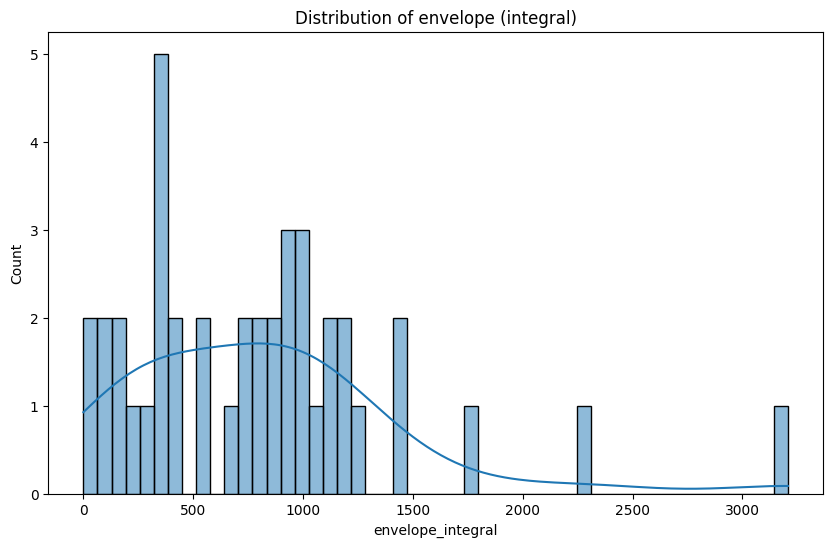

In [32]:
#| echo: false

plt.figure(figsize=(10, 6))
sns.histplot(data=features_df, x='envelope_integral', bins=50, kde=True)
plt.title('Distribution of envelope (integral)')
plt.show()

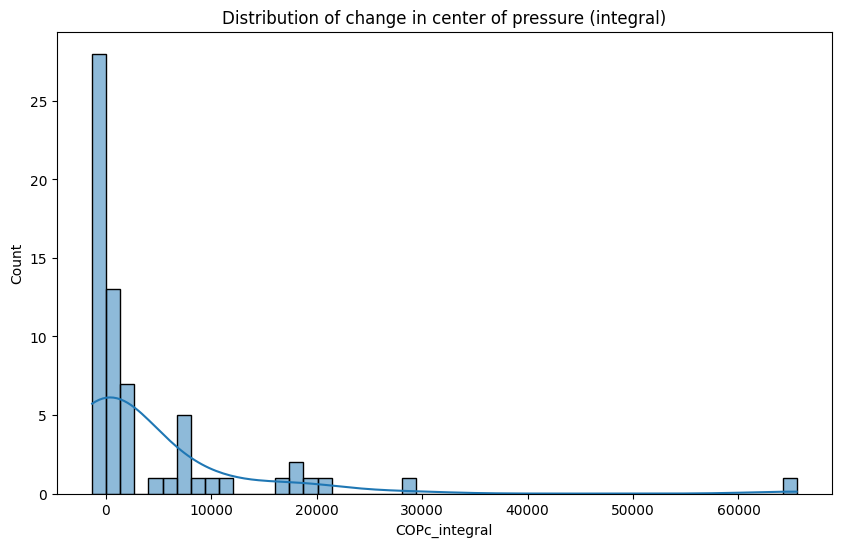

In [33]:
#| echo: false

plt.figure(figsize=(10, 6))
sns.histplot(data=features_df, x='COPc_integral', bins=50, kde=True)
plt.title('Distribution of change in center of pressure (integral)')
plt.show()

These are for the features in instantaneous form (peak mean)

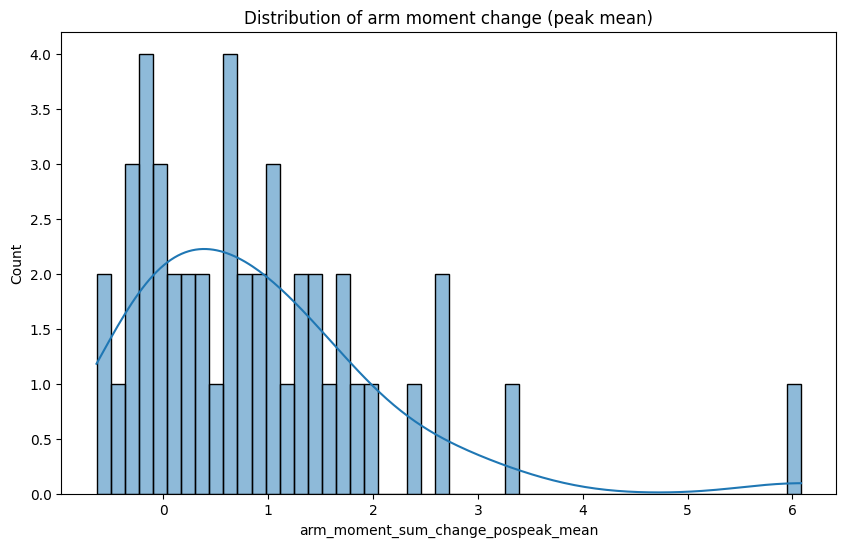

In [34]:
#| echo: false

plt.figure(figsize=(10, 6))
sns.histplot(data=features_df, x='arm_moment_sum_change_pospeak_mean', bins=50, kde=True)
plt.title('Distribution of arm moment change (peak mean)')
plt.show()

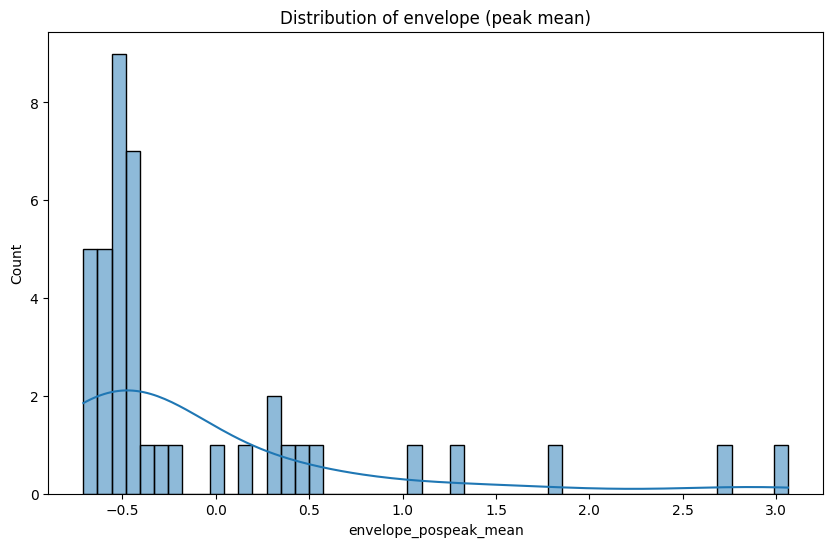

In [35]:
#| echo: false

plt.figure(figsize=(10, 6))
sns.histplot(data=features_df, x='envelope_pospeak_mean', bins=50, kde=True)
plt.title('Distribution of envelope (peak mean)')
plt.show()

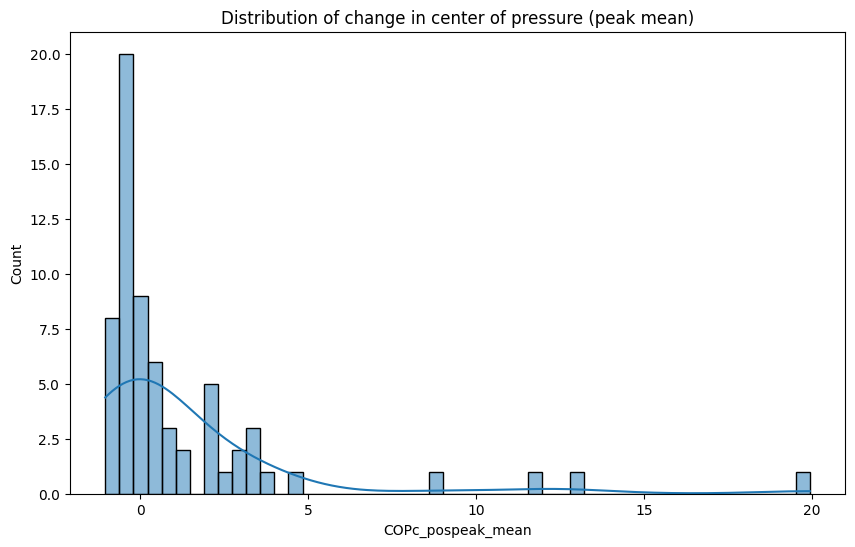

In [36]:
#| echo: false

plt.figure(figsize=(10, 6))
sns.histplot(data=features_df, x='COPc_pospeak_mean', bins=50, kde=True)
plt.title('Distribution of change in center of pressure (peak mean)')
plt.show()

Lastly, let's also look how are these three measures correlated with each other

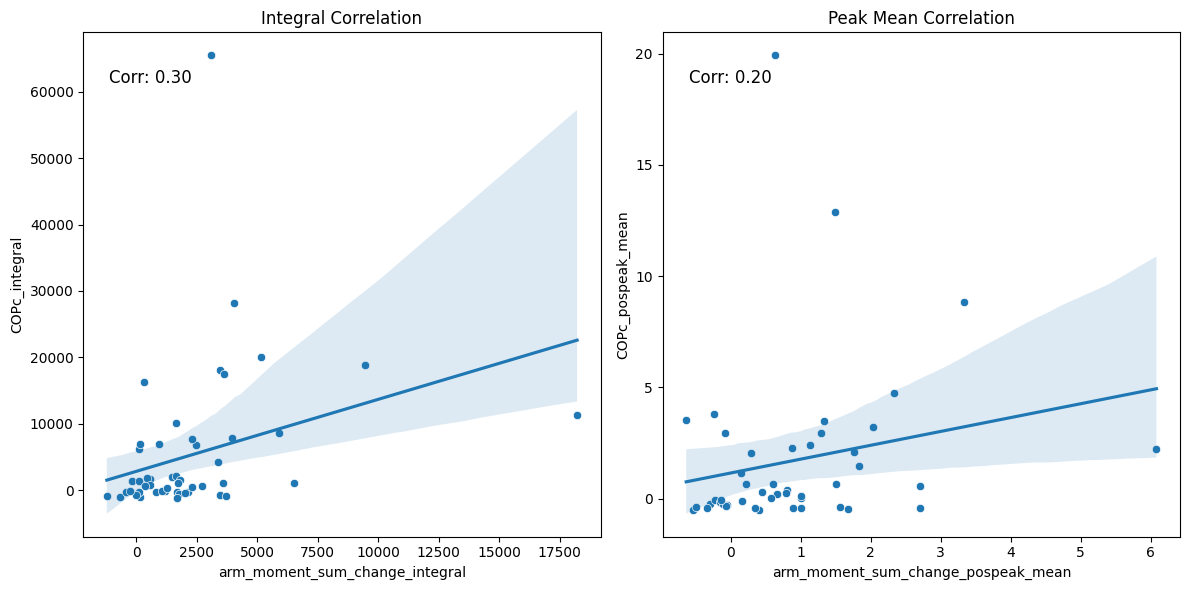

In [44]:
#| echo: false

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Integral correlation
sns.scatterplot(data=features_df, x='arm_moment_sum_change_integral', y='COPc_integral', ax=axes[0])
sns.regplot(data=features_df, x='arm_moment_sum_change_integral', y='COPc_integral', scatter=False, ax=axes[0])
correlation1 = features_df['arm_moment_sum_change_integral'].corr(features_df['COPc_integral'])
axes[0].text(0.05, 0.9, f'Corr: {correlation1:.2f}', fontsize=12, transform=axes[0].transAxes)
axes[0].set_title('Integral Correlation')

# Second plot: Pospeak correlation
sns.scatterplot(data=features_df, x='arm_moment_sum_change_pospeak_mean', y='COPc_pospeak_mean', ax=axes[1])
sns.regplot(data=features_df, x='arm_moment_sum_change_pospeak_mean', y='COPc_pospeak_mean', scatter=False, ax=axes[1])
correlation2 = features_df['arm_moment_sum_change_pospeak_mean'].corr(features_df['COPc_pospeak_mean'])
axes[1].text(0.05, 0.9, f'Corr: {correlation2:.2f}', fontsize=12, transform=axes[1].transAxes)
axes[1].set_title('Peak Mean Correlation')

plt.tight_layout()
plt.show()

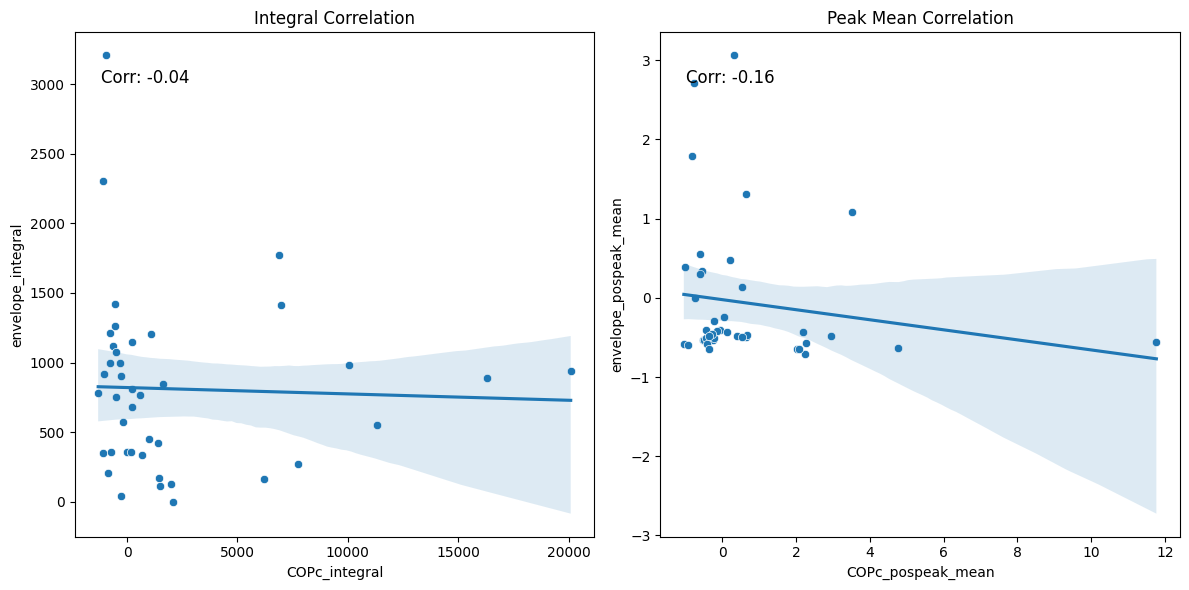

In [46]:
#| echo: false

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Integral correlation
sns.scatterplot(data=features_df, x='COPc_integral', y='envelope_integral', ax=axes[0])
sns.regplot(data=features_df, x='COPc_integral', y='envelope_integral', scatter=False, ax=axes[0])
correlation1 = features_df['COPc_integral'].corr(features_df['envelope_integral'])
axes[0].text(0.05, 0.9, f'Corr: {correlation1:.2f}', fontsize=12, transform=axes[0].transAxes)
axes[0].set_title('Integral Correlation')

# Second plot: Pospeak correlation
sns.scatterplot(data=features_df, x='COPc_pospeak_mean', y='envelope_pospeak_mean', ax=axes[1])
sns.regplot(data=features_df, x='COPc_pospeak_mean', y='envelope_pospeak_mean', scatter=False, ax=axes[1])
correlation2 = features_df['COPc_pospeak_mean'].corr(features_df['envelope_pospeak_mean'])
axes[1].text(0.05, 0.9, f'Corr: {correlation2:.2f}', fontsize=12, transform=axes[1].transAxes)
axes[1].set_title('Peak Mean Correlation')

plt.tight_layout()
plt.show()

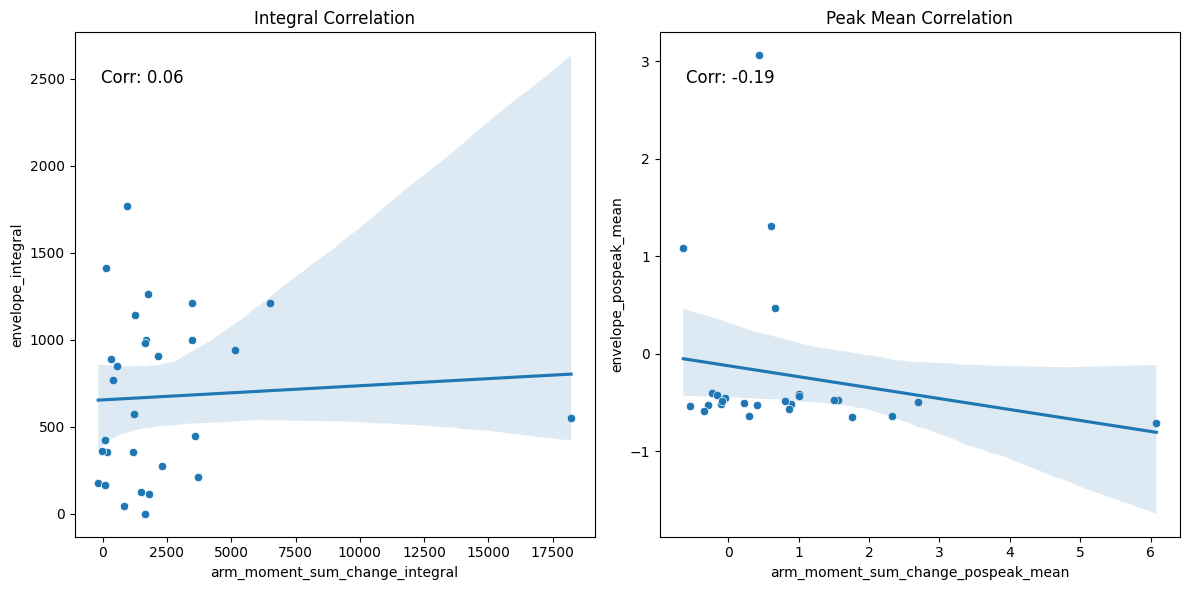

In [47]:
#| echo: false

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Integral correlation
sns.scatterplot(data=features_df, x='arm_moment_sum_change_integral', y='envelope_integral', ax=axes[0])
sns.regplot(data=features_df, x='arm_moment_sum_change_integral', y='envelope_integral', scatter=False, ax=axes[0])
correlation1 = features_df['arm_moment_sum_change_integral'].corr(features_df['envelope_integral'])
axes[0].text(0.05, 0.9, f'Corr: {correlation1:.2f}', fontsize=12, transform=axes[0].transAxes)
axes[0].set_title('Integral Correlation')

# Second plot: Pospeak correlation
sns.scatterplot(data=features_df, x='arm_moment_sum_change_pospeak_mean', y='envelope_pospeak_mean', ax=axes[1])
sns.regplot(data=features_df, x='arm_moment_sum_change_pospeak_mean', y='envelope_pospeak_mean', scatter=False, ax=axes[1])
correlation2 = features_df['arm_moment_sum_change_pospeak_mean'].corr(features_df['envelope_pospeak_mean'])
axes[1].text(0.05, 0.9, f'Corr: {correlation2:.2f}', fontsize=12, transform=axes[1].transAxes)
axes[1].set_title('Peak Mean Correlation')

plt.tight_layout()
plt.show()

Because we will proceed with XGBoost per modality, we will also save the data separately for each modality.

In [25]:
# Separate data into three dfs based on modality
features_df_gesture = features_df[features_df["modality"] == "gebaren"]
features_df_combination = features_df[features_df["modality"] == "combinatie"]
features_df_vocal = features_df[features_df["modality"] == "geluiden"]

# Save them
features_df_gesture.to_csv(datafolder + "features_df_gesture.csv", index=False)
features_df_combination.to_csv(datafolder + "features_df_combination.csv", index=False)
features_df_vocal.to_csv(datafolder + "features_df_vocal.csv", index=False)